In [1]:
import crystal_mod as cry_mod 
import mode_analysis_code_original as ma
import matplotlib.pyplot as plt 
import numpy as np
import FMM3D.python.fmm3dpy as fmm
from scipy import optimize

In [33]:
num_ions=236
mass_amu=9.012182
vtrap=(0.0, -1750.0, -1970.0)
v_wall=30.
frot=180000
method='bfgs'
frot_kHz = 1e-3*frot 

ma_instance=ma.ModeAnalysis(
            N      = num_ions,
            ionmass= mass_amu,
            Vtrap  = vtrap,
            omega_z = 2*np.pi*1.58e6,
            Vwall  = v_wall,
            frot   = frot_kHz,
            method = method)
ma_instance.run()

False
Desired error not necessarily achieved due to precision loss.
False
Desired error not necessarily achieved due to precision loss.
False
Desired error not necessarily achieved due to precision loss.
False
Desired error not necessarily achieved due to precision loss.
False
Desired error not necessarily achieved due to precision loss.
False
Desired error not necessarily achieved due to precision loss.
(472,)


In [34]:
pos = ma_instance.uE
pos0 = ma_instance.u0E

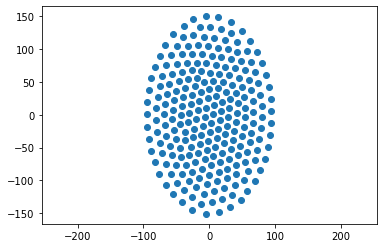

[-5.22993011e-06 -2.42952316e-06  5.47655252e-06 -6.99006640e-06
 -1.93488548e-05 -1.76281682e-05 -1.51556672e-05  6.01021290e-06
  2.49503256e-05  7.19500158e-06  1.80891091e-05  3.17269408e-06
  1.04932874e-06 -9.73158815e-06 -1.17211103e-05 -3.17168765e-05
 -2.81661546e-05 -1.23384829e-05 -1.72601085e-07 -7.38690444e-06
  1.53243370e-05  2.17765503e-05  3.13999869e-05  3.08421697e-05
  1.61454485e-05  1.14946807e-05  2.48250538e-05  9.06413553e-06
 -1.52349465e-06 -1.46360304e-05 -2.45778108e-05 -3.72789826e-05
 -3.02422254e-05 -2.56442951e-05 -3.90886156e-05 -4.13094132e-05
 -2.20931862e-05 -1.07370267e-05  9.37802401e-07  3.06127603e-05
  3.49929474e-05  4.33150665e-05  1.96571759e-05  5.22907350e-05
  2.72509752e-05  3.84937756e-05  3.27200222e-05  2.21306460e-05
  1.67622972e-05  3.33207808e-06 -6.99865509e-06 -2.07792739e-05
 -2.81401727e-05 -5.38143407e-05 -3.68523203e-05 -5.48760453e-05
 -4.13863200e-05 -3.60001838e-05 -3.27481352e-05 -2.68107021e-05
 -1.87337289e-05 -4.18992

In [35]:
ax = plt.subplot()
ax.axis('equal')
ax.scatter(pos[0:ma_instance.Nion]*1e6,pos[ma_instance.Nion:]*1e6)
plt.show()
print(pos[:num_ions])
print(pos[num_ions:])

In [36]:
def force_penning(pos_array, Nion):
        """
        Computes the net forces acting on each ion in the crystal;
        used as the jacobian by find_eq_pos to minimize the potential energy
        of a crystal configuration.

        :param pos_array: crystal to find forces of.
        :return: a vector of size 2N describing the x forces and y forces.
        """
        wr = 180000*2*np.pi
        wz = 2*np.pi*1.58e6
        q= 1.60217663 * 10**-19
        eps0 = 8.85418782*10**-12
        m = 9.012182*1.66057e-27
        wz = 2*np.pi*1.58e6
        wc = 4.4588*q/m
        V0=(0.5 * m * wz**2) / q
        Volt_w = 30
        Volt_0 = V0 
        delta = 1612.*Volt_w / Volt_0
        Vw = 0.5*(m*wz**2/q)*delta
        
        x = pos_array[0:Nion]
        y = pos_array[Nion:2*Nion]
        
        dx = x.reshape((x.size, 1)) - x
        dy = y.reshape((y.size, 1)) - y
        rsep = np.sqrt(dx ** 2 + dy ** 2)

        # Calculate coulomb force on each ion
        with np.errstate(divide='ignore'):
            Fc = np.where(rsep != 0., rsep ** (-2), 0)

        with np.errstate(divide='ignore', invalid='ignore'):
            fx = np.where(rsep != 0., np.float64((dx / rsep) * Fc), 0)*q**2/(4*np.pi*eps0)
            fy = np.where(rsep != 0., np.float64((dy / rsep) * Fc), 0)*q**2/(4*np.pi*eps0)

        '''
        dx = x.reshape((x.size, 1)) - x
        dy = y.reshape((y.size, 1)) - y
        dz = z.reshape((z.size, 1)) - z
        rsep = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

        # Calculate coulomb force on each ion
        with np.errstate(divide='ignore'):
            Fc = np.where(rsep != 0., rsep ** (-2), 0)

        with np.errstate(divide='ignore', invalid='ignore'):
            fx = np.where(rsep != 0., np.float64((dx / rsep) * Fc), 0)
            fy = np.where(rsep != 0., np.float64((dy / rsep) * Fc), 0)
            fz = np.where(rsep != 0., np.float64((dz / rsep) * Fc), 0)
        '''

        # total force on each ion

        """ Deprecated version below which uses anharmonic trap potentials
        Ftrapx = (-m * wr ** 2 - q * self.Coeff[2] + q * B * wr + 2 * self.Cw2) * x \
            - 4 * q * self.Coeff[3] * (x ** 3 + x * y ** 2) + 3 * self.Cw3 * (x ** 2 - y ** 2)
        Ftrapy = (-m * wr ** 2 - q * self.Coeff[2] + q * B * wr - 2 * self.Cw2) * y \
            - 4 * q * self.Coeff[3] * (y ** 3 + y * x ** 2) - 6 * self.Cw3 * x * y

        # Ftrap =  (m*w**2 + q*self.V0 - 2*q*self.Vw - q*self.B* w) * pos_array
        """
        Ftrapx = -m * (wr ** 2 - wr * wc + 0.5*wz**2 -
                                 q*Vw) * x
        Ftrapy = -m * (wr ** 2 - wr * wc + 0.5*wz**2 +
                                 q*Vw) * y
        Fx = -np.sum(fx, axis=1) + Ftrapx
        Fy = -np.sum(fy, axis=1) + Ftrapy

        return np.array([Fx, Fy]).flatten()

In [37]:
nion = 236
forces = force_penning(pos, nion)
forces2D = np.zeros(nion)
for i in range(nion):
    forces2D = (forces[i]**2 + forces[i+nion]**2)**0.5
print(np.mean(forces2D))

2.251792976754224e-18


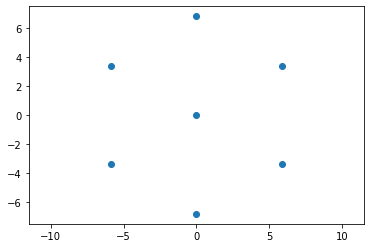

[ 0.00000000e+00  0.00000000e+00  5.87905692e-06  5.87905692e-06
  0.00000000e+00 -5.87905692e-06 -5.87905692e-06]
[ 0.00000000e+00  6.78855019e-06  3.39427509e-06 -3.39427509e-06
 -6.78855019e-06 -3.39427509e-06  3.39427509e-06]


In [5]:
ax = plt.subplot()
ax.axis('equal')
ax.scatter(pos0[0:ma_instance.Nion]*1e6,pos0[ma_instance.Nion:]*1e6)
plt.show()
print(pos0[:num_ions])
print(pos0[num_ions:])

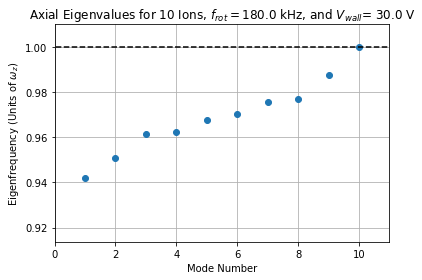

[0.94196335 0.95068552 0.96143477 0.962406   0.96748798 0.97018152
 0.9758132  0.97707469 0.98776937 1.        ]
[2.96958565e-03 6.75071009e-03 7.23495689e-03 9.55261041e-03
 9.83408335e-03 1.16189620e-02 1.26467813e-02 1.41073928e-02
 1.50496484e-02 1.76049347e-02 4.58818195e+00 4.59082922e+00
 4.59311763e+00 4.59338235e+00 4.59457647e+00 4.59513548e+00
 4.59620621e+00 4.59639899e+00 4.59864110e+00 4.60042158e+00]


In [90]:
ma_instance.show_axial_Evals()
print(ma_instance.axialEvals)
print(ma_instance.planarEvals)
evals = np.sort(np.append(ma_instance.axialEvalsE,ma_instance.planarEvalsE))

Text(0, 0.5, '$Frequency\\; (MHz)$')

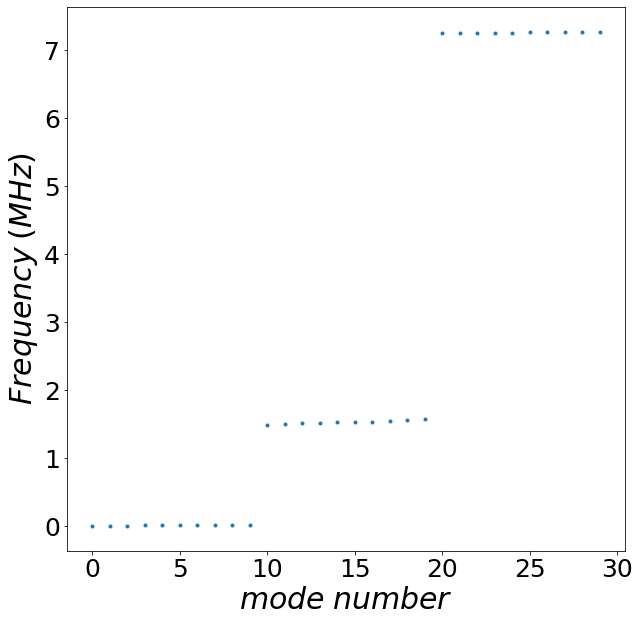

In [91]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.plot(np.arange(10*3), evals/(2*np.pi*10**6), linestyle = " ", marker = ".")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$mode\;number$',fontsize = 30)
plt.ylabel(r'$Frequency\; (MHz)$',fontsize = 30)

In [191]:
print(ma_instance.axialEvalsE/(2*np.pi))
print(ma_instance.planarEvalsE/(2*np.pi))

[1488302.09183657 1502083.12450158 1519066.94090341 1520601.47458986
 1528631.00394449 1532886.79433732 1541784.86235623 1543778.01596337
 1560675.59956458 1580000.        ]
[4.69194532e+03 1.06661219e+04 1.14312319e+04 1.50931245e+04
 1.55378517e+04 1.83579600e+04 1.99819145e+04 2.22896806e+04
 2.37784445e+04 2.78157969e+04 7.24932748e+06 7.25351016e+06
 7.25712585e+06 7.25754411e+06 7.25943082e+06 7.26031405e+06
 7.26200581e+06 7.26231041e+06 7.26585294e+06 7.26866609e+06]


In [35]:
sources = np.array([pos[0:ma_instance.Nion],pos[ma_instance.Nion:],np.zeros(ma_instance.Nion)])
charges = np.full(ma_instance.Nion, 1.602176597458587e-19)
fmm.lfmm3d(eps=10**-7,sources=sources,charges=charges,dipvec=None,targets=None,pg=2,pgt=0,nd=1)

In [3]:
import mode_analysis_code_original_fmm as ma_fmm

In [6]:
num_ions=7
mass_amu=9.012182
vtrap=(0.0, -1750.0, -1970.0)
v_wall=5.
frot=180000
method='bfgs'
frot_kHz = 1e-3*frot 

ma_instance_fmm=ma_fmm.ModeAnalysis(
            N      = num_ions,
            ionmass= mass_amu,
            Vtrap  = vtrap,
            omega_z = 2*np.pi*1.58e6,
            Vwall  = v_wall,
            frot   = frot_kHz,
            method = method)

eq_pos_3D = np.append(ma_instance.uE, np.zeros(7))
#print(eq_pos_3D)
ma_instance_fmm.run3D(eq_pos_3D)

In [28]:
sfx = "_rot_236i_vel_pert_030622.dat"
load_xrot = np.loadtxt("x" + sfx + ".csv")
load_yrot = np.loadtxt("y" + sfx + ".csv")
load_zrot = np.loadtxt("z" + sfx + ".csv")
load_vxrot = np.loadtxt("vx" + sfx + ".csv")
load_vyrot = np.loadtxt("vy" + sfx + ".csv")
load_vzrot = np.loadtxt("vz" + sfx + ".csv")
load_xrot.shape

(50001, 236)

In [31]:
load_rrot = np.zeros((50001,236))
#load_rrot = np.zeros((100001,10))
load_rrot = np.sqrt(load_xrot**2+load_yrot**2)
print(load_rrot.shape)
ps, freqs_norm = cry_mod.psd(load_zrot, 10**-9)
print(np.diff(freqs_norm))

(50001, 236)
[0.0199996 0.0199996 0.0199996 ... 0.0199996 0.0199996 0.0199996]


[1.58216281e-03 5.30369602e-03 5.29256804e-03 2.90498271e-03
 2.63130709e-03 2.34101445e-03 5.54069476e-03 4.12071986e-03
 2.46549353e-03 1.93094672e-03 2.11707620e-03 2.84637974e-03
 3.11296020e-03 3.49581580e-03 1.49848536e-03 2.25803709e-03
 2.21751017e-03 2.35113508e-03 2.34864538e-03 1.77260117e-03
 8.92987932e-04 3.23985447e-03 1.00018379e-03 2.90973175e-03
 6.32172213e-04 3.14861491e-03 2.65464690e-03 1.00634842e-03
 2.61296037e-03 2.24270589e-03 8.41560783e-04 3.44716998e-03
 9.85544498e-04 1.32816317e-03 1.79449035e-03 1.65809368e-03
 1.98501719e-03 2.48509133e-03 1.49940193e-03 1.13181085e-03
 2.52528508e-03 1.36056731e-03 1.47856347e-03 2.04588650e-03
 8.05180858e-04 1.42211922e-03 1.74926300e-03 1.08525764e-03
 2.32136294e-03 1.22713325e-04 1.70032167e-03 1.49895691e-03
 6.47828583e-04 1.58529991e-03 1.89263432e-03 1.41980916e-03
 2.32064620e-03 7.08065880e-04 1.57829522e-03 1.18542369e-03
 1.16880788e-03 2.18729104e-03 1.36925022e-03 1.17535526e-03
 9.78865550e-04 1.397118

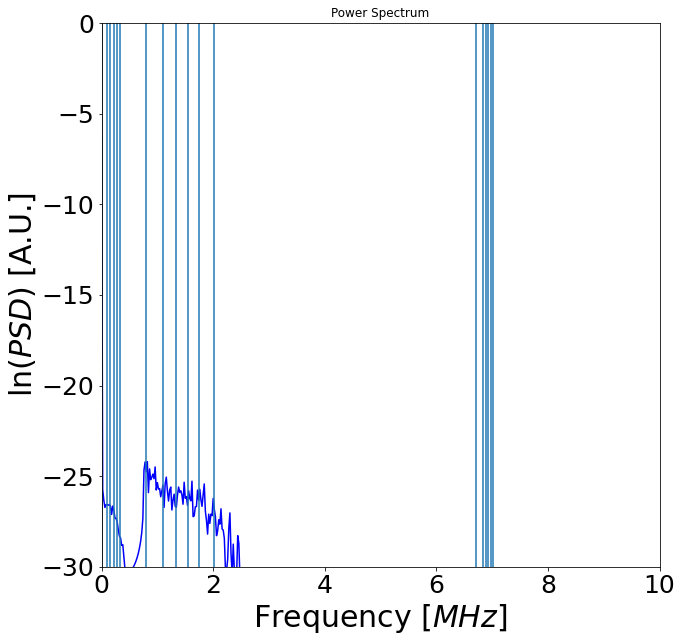

In [32]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_xlim(6.5,7.2)
ax.set_xlim(0,10)
cry_mod.plot_psd(freqs_norm,ps,ax,fig)
#ax.axvline(x = 6.8)
#ax.axvline(x = 2.2)
#ax.axvline(x = 0.4)
#ax.axvline(x = 1.54)
#ax.axvline(x = 7.26)
i=0
while i < ma_instance_fmm.EvalsE3D.size:
    ax.axvline(x = ma_instance_fmm.EvalsE3D[i]/(2*np.pi*10**6))
    i+=40
print(np.diff(ma_instance_fmm.EvalsE3D/(2*np.pi*10**6)))

In [ ]:
ps_rad,freq_norm_rad = cry_mod.psd(load_zrot,10**-9)

fig = plt.figure(figsize=(11,8.5),constrained_layout=False)
gs  = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

num_particles = 256
#mag_modes = np.arange(0,num_particles)
#normal_freqs = all_normal_freqs[mag_modes]
#ax1.axvline(omegaminus/units/np.pi/2
#            ,color='c'
#            ,label=r'$f_-$'
#            ,zorder=2)
cry_mod.plot_psd(freq_norm_rad,ps_rad,ax1,fig,label='C++ simulation',color='b')    
ax1.fill_between(freq_norm_rad,ps_rad,-30
        ,color='b'
        ,zorder=3
        )

secax_x = ax1.secondary_xaxis('top')
secax_x.set_xlabel('Mode #',fontsize=20)
labels  = np.array(list(map(str, (mag_modes+1))),dtype='<U5')
print(normal_freqs)
print(labels)
#freqs,labels = get_mode_ticks(labels,normal_freqs)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
#secax_x.set_xticks(freqs) 
secax_x.set_xticklabels(labels,fontsize=16)
ax1.legend(loc='lower left')
ax1.set_title('ExB Branch',fontsize=30)
ax1.set_xlim(-1,1)




plt.tight_layout()
#plt.savefig(pdir+'psd_comparison_nlVlin_'+lab_sim+'.png')
plt.show()

In [20]:
#sfx = "_rot_dec_1000i_w2_d7_f7_t10.dat"
sfx = "_1000i_mode_spectrum.dat"
load_xrot = np.loadtxt("x" + sfx + ".csv")
load_yrot = np.loadtxt("y" + sfx + ".csv")
load_zrot = np.loadtxt("z" + sfx + ".csv")
load_vxrot = np.loadtxt("vx" + sfx + ".csv")
load_vyrot = np.loadtxt("vy" + sfx + ".csv")
load_vzrot = np.loadtxt("vz" + sfx + ".csv")
'''
times_rec = 401
num_particles = 1000
load_pos_rot3D = np.zeros((times_rec,3,num_particles))
load_pos_rot2D = np.zeros((times_rec,2,num_particles))
load_vel_rot3D = np.zeros((times_rec,3,num_particles))
load_pos_rot3D[:,0,:] = load_xrot
load_pos_rot3D[:,1,:] = load_yrot
load_pos_rot3D[:,2,:] = load_zrot
load_pos_rot2D[:,0,:] = load_xrot
load_pos_rot2D[:,1,:] = load_yrot
load_vel_rot3D[:,0,:] = load_vxrot
load_vel_rot3D[:,1,:] = load_vyrot
load_vel_rot3D[:,2,:] = load_vzrot
'''

'\ntimes_rec = 401\nnum_particles = 1000\nload_pos_rot3D = np.zeros((times_rec,3,num_particles))\nload_pos_rot2D = np.zeros((times_rec,2,num_particles))\nload_vel_rot3D = np.zeros((times_rec,3,num_particles))\nload_pos_rot3D[:,0,:] = load_xrot\nload_pos_rot3D[:,1,:] = load_yrot\nload_pos_rot3D[:,2,:] = load_zrot\nload_pos_rot2D[:,0,:] = load_xrot\nload_pos_rot2D[:,1,:] = load_yrot\nload_vel_rot3D[:,0,:] = load_vxrot\nload_vel_rot3D[:,1,:] = load_vyrot\nload_vel_rot3D[:,2,:] = load_vzrot\n'

In [3]:
num_ions = 236
load_xrot = np.loadtxt('x_236i_eq_scipy.csv')
load_yrot = np.loadtxt('y_236i_eq_scipy.csv')
load_zrot = np.loadtxt('z_236i_eq_scipy.csv')
#start_pos_x = load_xrot[-1]
#start_pos_y = load_yrot[-1]
#start_pos_z = load_zrot[-1]
start_pos_x = load_xrot
start_pos_y = load_yrot
start_pos_z = load_zrot

In [22]:
num_ions=1000
mass_amu=9.012182
omega_z = 2*np.pi*1.58e6
q = 1.602176597458587e-19
Bz =4.4588
m = mass_amu*1.66057e-27
wc = q*Bz/m
omega_R = (wc-np.sqrt(wc**2-6*omega_z**2))/2
mass_amu=9.012182
vtrap=(0.0, -1750.0, -1970.0)
v_wall=30.
frot=omega_R/(2*np.pi)
method='bfgs'
frot_kHz = 1e-3*frot 

ma_instance_fmm=ma_fmm.ModeAnalysis(
            N      = num_ions,
            ionmass= mass_amu,
            Vtrap  = vtrap,
            omega_z = 2*np.pi*1.58e6,
            Vwall  = v_wall,
            frot   = frot_kHz,
            method = method)

#pos_3D = np.concatenate([load_pos_rot3D[-1,0,:],load_pos_rot3D[-1,1,:],load_pos_rot3D[-1,2,:]])
pos_3D = np.concatenate([load_xrot,load_yrot,load_zrot])
print(pos_3D.shape)
#eq_pos_3D = np.append(ma_instance.uE, np.zeros(7))
#print(eq_pos_3D)
ma_instance_fmm.run3D(pos_3D)

(3000,)


In [5]:
num_ions=5000
mass_amu=9.012182
omega_z = 2*np.pi*1.58e6
q = 1.602176597458587e-19
Bz =4.4588
m = mass_amu*1.66057e-27
wc = q*Bz/m
omega_R = (wc-np.sqrt(wc**2-6*omega_z**2))/2
mass_amu=9.012182
vtrap=(0.0, -1750.0, -1970.0)
v_wall=30.
frot=omega_R/(2*np.pi)
method='bfgs'
frot_kHz = 1e-3*frot 

ma_instance_fmm=ma_fmm.ModeAnalysis(
            N      = num_ions,
            ionmass= mass_amu,
            Vtrap  = vtrap,
            omega_z = 2*np.pi*1.58e6,
            Vwall  = v_wall,
            frot   = frot_kHz,
            method = method)

#pos_3D = np.concatenate([start_pos_x,start_pos_y,start_pos_z])
pos_3D = (np.random.rand(num_ions*3)-0.5)*10**-5
print(pos_3D.shape)
#eq_pos_3D = np.append(ma_instance.uE, np.zeros(7))
#print(eq_pos_3D)
ma_instance_fmm.run3D(pos_3D)

(15000,)
False
Desired error not necessarily achieved due to precision loss.
first minimization: 1652158.441687792


In [89]:
num_ions=10
mass_amu=9.012182
omega_z = 2*np.pi*1.58e6
q = 1.602176597458587e-19
Bz =4.4588
m = mass_amu*1.66057e-27
wc = q*Bz/m
#omega_R = (wc-np.sqrt(wc**2-6*omega_z**2))/2
mass_amu=9.012182
vtrap=(0.0, -1750.0, -1970.0)
v_wall=30.
frot=180000.
method='bfgs'
frot_kHz = 1e-3*frot 

ma_instance=ma.ModeAnalysis(
            N      = num_ions,
            ionmass= mass_amu,
            Vtrap  = vtrap,
            omega_z = 2*np.pi*1.58e6,
            Vwall  = v_wall,
            frot   = frot_kHz,
            method = method)

ma_instance.run()
print(ma_instance.Cw)
pos = ma_instance.uE
print(pos)
pert = np.empty(len(pos))
for i in range(len(pos)):
    pert[i] = np.random.normal(0, 10**2)
pos_3D = np.concatenate([pos[:num_ions],pos[num_ions:2*num_ions],np.zeros(num_ions)])
print(pos_3D.shape)
#eq_pos_3D = np.append(ma_instance.uE, np.zeros(7))
#print(eq_pos_3D)
ma_instance_fmm.run3D(pos_3D)

(20,)
0.010506682557180371
[ 2.03301781e-05  2.26541828e-13  1.68203146e-05  1.68203142e-05
 -6.42031088e-14 -2.03301780e-05 -1.68203144e-05 -1.80738511e-13
 -4.04206073e-13 -1.68203147e-05 -1.73657370e-13  1.05725861e-05
  2.34168105e-05 -2.34168106e-05 -1.05725863e-05  1.17036758e-13
  2.34168107e-05  3.82354994e-05 -3.82354993e-05 -2.34168102e-05]
(30,)


In [8]:
sfx = "_10i_eq_scipy"
load_xrot = np.loadtxt("x" + sfx + ".csv")
load_yrot = np.loadtxt("y" + sfx + ".csv")
load_zrot = np.loadtxt("z" + sfx + ".csv")
#load_xrot = np.zeros(10)
#load_yrot = np.zeros(10)
#for j in range(10):
#    load_xrot[j] = np.cos(334.47501329-np.pi/2)*load_xrot_raw[j]+np.sin(334.47501329-np.pi/2)*load_yrot_raw[j] #rotation
#    load_yrot[j] = -np.sin(334.47501329-np.pi/2)*load_xrot_raw[j]+np.cos(334.47501329-np.pi/2)*load_yrot_raw[j] #rotation
#load_xrot = np.loadtxt("x" + sfx + ".csv")
#load_yrot = np.loadtxt("y" + sfx + ".csv")

In [64]:
sfx = "_236i_eq_scipy"
load_xrot = np.loadtxt("x" + sfx + ".csv")
load_yrot = np.loadtxt("y" + sfx + ".csv")
load_zrot = np.loadtxt("z" + sfx + ".csv")

In [8]:
load_xrot = np.loadtxt("236i_ma_min_x.csv")
load_yrot = np.loadtxt("236i_ma_min_y.csv")
load_zrot = np.loadtxt("236i_ma_min_z.csv")

In [9]:
num_ions=236
mass_amu=9.012182
omega_z = 2*np.pi*1.58e6
q = 1.602176597458587e-19
Bz =4.4588
m = mass_amu*1.66057e-27
wc = q*Bz/m
omega_R = (wc-np.sqrt(wc**2-6*omega_z**2))/2
mass_amu=9.012182
vtrap=(0.0, -1750.0, -1970.0)
v_wall=30.
frot=omega_R/(2*np.pi)
method='cg'
frot_kHz = 1e-3*frot 

ma_instance_fmm=ma_fmm.ModeAnalysis(
            N      = num_ions,
            ionmass= mass_amu,
            Vtrap  = vtrap,
            omega_z = 2*np.pi*1.58e6,
            Vwall  = v_wall,
            frot   = frot_kHz,
            method = method)

#pos_3D = np.concatenate([load_pos_rot3D[-1,0,:],load_pos_rot3D[-1,1,:],load_pos_rot3D[-1,2,:]])
pos_3D = np.concatenate([load_xrot,load_yrot,load_zrot])
print(pos_3D.shape)
#eq_pos_3D = np.append(ma_instance.uE, np.zeros(7))
#print(eq_pos_3D)
ma_instance_fmm.run3D_eigen(pos_3D)

(708,)


In [10]:
num_ions=10
mass_amu=9.012182
omega_z = 2*np.pi*1.58e6
q = 1.602176597458587e-19
Bz =4.4588
m = mass_amu*1.66057e-27
wc = q*Bz/m
omega_R = (wc-np.sqrt(wc**2-6*omega_z**2))/2
mass_amu=9.012182
vtrap=(0.0, -1750.0, -1970.0)
v_wall=30.
frot=omega_R/(2*np.pi)
method='bfgs'
frot_kHz = 1e-3*frot 

ma_instance_fmm=ma_fmm.ModeAnalysis(
            N      = num_ions,
            ionmass= mass_amu,
            Vtrap  = vtrap,
            omega_z = 2*np.pi*1.58e6,
            Vwall  = v_wall,
            frot   = frot_kHz,
            method = method)

#pos_3D = np.concatenate([load_pos_rot3D[-1,0,:],load_pos_rot3D[-1,1,:],load_pos_rot3D[-1,2,:]])
pos_3D = np.concatenate([load_xrot,load_yrot,load_zrot])
print(pos_3D.shape)
#eq_pos_3D = np.append(ma_instance.uE, np.zeros(7))
#print(eq_pos_3D)
ma_instance_fmm.run3D(pos_3D)

(30,)


In [11]:
print(ma_instance_fmm.EvalsE3D)

[1.07929279e+01 9.95181507e+03 4.32759200e+04 7.65301057e+04
 9.47826504e+04 1.11315640e+05 1.26024668e+05 1.60837880e+05
 1.86729126e+05 2.02220279e+05 2.14352775e+05 2.27654757e+05
 2.45539089e+05 2.65098394e+05 2.87063253e+05 2.96478514e+05
 3.10666180e+05 3.24599207e+05 3.39371824e+05 3.54128798e+05
 3.65266380e+05 3.70877189e+05 3.91233795e+05 3.97518135e+05
 4.15800519e+05 4.19772574e+05 4.39555905e+05 4.56235543e+05
 4.62558617e+05 4.78976331e+05 4.93067668e+05 4.98355350e+05
 5.20014558e+05 5.26206916e+05 5.34552012e+05 5.45827127e+05
 5.56245237e+05 5.68717468e+05 5.84331757e+05 5.93752777e+05
 6.00864155e+05 6.16730989e+05 6.25279685e+05 6.34569774e+05
 6.47424458e+05 6.52483558e+05 6.61418997e+05 6.72409940e+05
 6.79228815e+05 6.93814369e+05 6.94585399e+05 7.05268835e+05
 7.14687059e+05 7.18757486e+05 7.28718219e+05 7.40609992e+05
 7.49530916e+05 7.64111966e+05 7.68560875e+05 7.78477596e+05
 7.85925833e+05 7.93269670e+05 8.07012824e+05 8.15616077e+05
 8.23001052e+05 8.291514

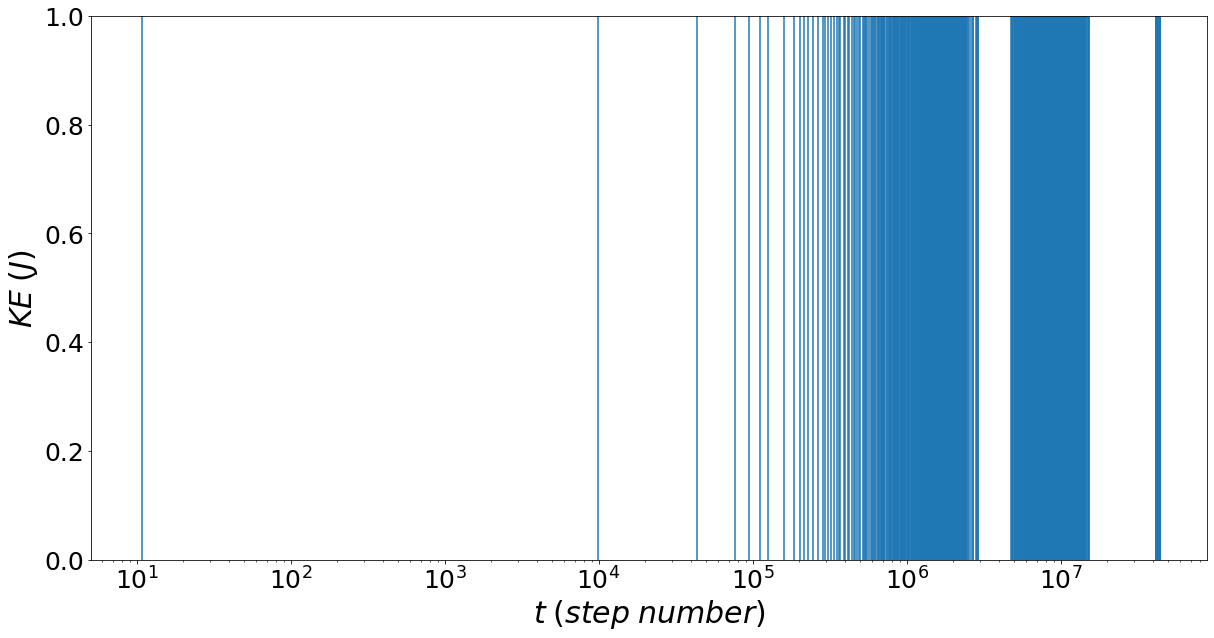

In [14]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()
ax.set_xscale('log')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$t\;(step\;number)$',fontsize = 30)
plt.ylabel(r'$KE\;(J)$',fontsize = 30)
#for eig3D in ma_instance_fmm.EvalsE3D:
#    ax.axvline(x = eig3D)
per=1
c=0
i=0
while i < ma_instance_fmm.EvalsE3D.size:
    if c% per ==0:
        ax.axvline(x = ma_instance_fmm.EvalsE3D[i])
    c+=1
    i+=1

Text(0, 0.5, '$Frequency\\; (MHz)$')

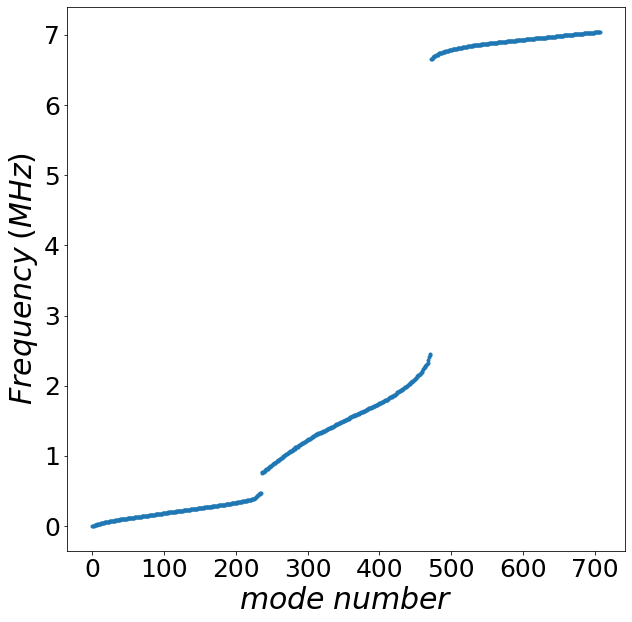

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.plot(np.arange(236*3), ma_instance_fmm.EvalsE3D/(2*np.pi*10**6), linestyle = " ", marker = ".")
plt.xlabel(r'$mode\;number$',fontsize = 30)
plt.ylabel(r'$Frequency\; (MHz)$',fontsize = 30)

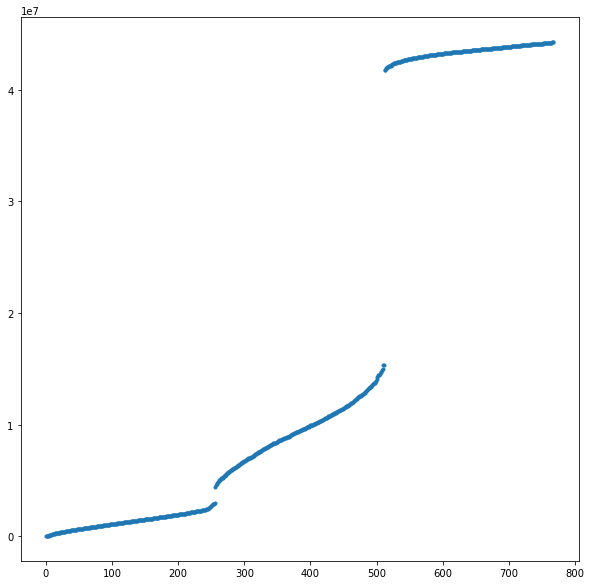

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.plot(np.arange(256*3), ma_instance_fmm.EvalsE3D, linestyle = " ", marker = ".")

[0.00000000e+00 3.25939086e+03 8.13473150e+03 2.27909014e+04
 2.84315728e+04 3.19418723e+04 3.38539973e+04 3.46113846e+04
 3.93981637e+04 4.60477925e+04 5.69143658e+04 6.22088993e+04
 6.58852143e+04 6.86167186e+04 7.83574228e+04 8.27216662e+04
 8.66445796e+04 9.01354960e+04 9.71269539e+04 9.86402076e+04
 1.03081106e+05 1.06711748e+05 1.10641161e+05 1.15426511e+05
 1.17623647e+05 1.21308347e+05 1.25128469e+05 1.31223704e+05
 1.35695068e+05 1.39555674e+05 1.40557533e+05 1.43542078e+05
 1.45522147e+05 1.53411248e+05 1.57356484e+05 1.59459710e+05
 1.61583104e+05 1.66999723e+05 1.68228625e+05 1.72125987e+05
 1.76818478e+05 1.83645166e+05 1.86776040e+05 1.89690037e+05
 1.91767190e+05 1.94941986e+05 1.99173931e+05 2.08658953e+05
 2.10558251e+05 2.13081227e+05 2.16405662e+05 2.19993599e+05
 2.23982773e+05 2.26999445e+05 2.29401221e+05 2.35708308e+05
 2.39567036e+05 2.42273141e+05 2.44027597e+05 2.47320151e+05
 2.54764801e+05 2.57402776e+05 2.59303212e+05 2.63414582e+05
 2.67394760e+05 2.710436

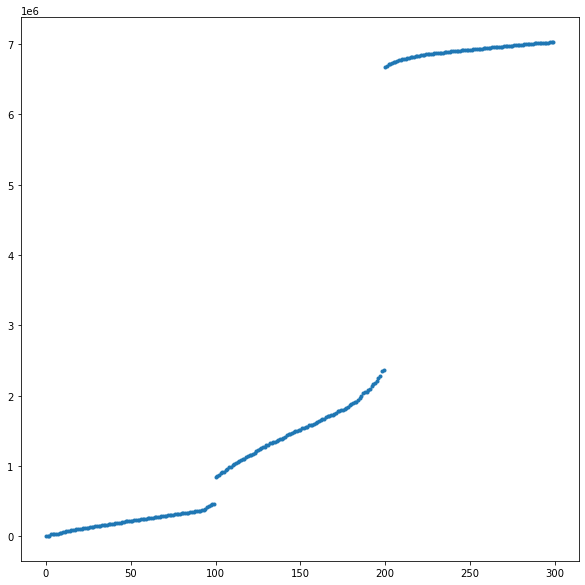

In [84]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.plot(np.arange(100*3), ma_instance_fmm.EvalsE3D/(2*np.pi), linestyle = " ", marker = ".")
print(ma_instance_fmm.EvalsE3D/(2*np.pi))

Text(0, 0.5, '$Frequency\\; (MHz)$')

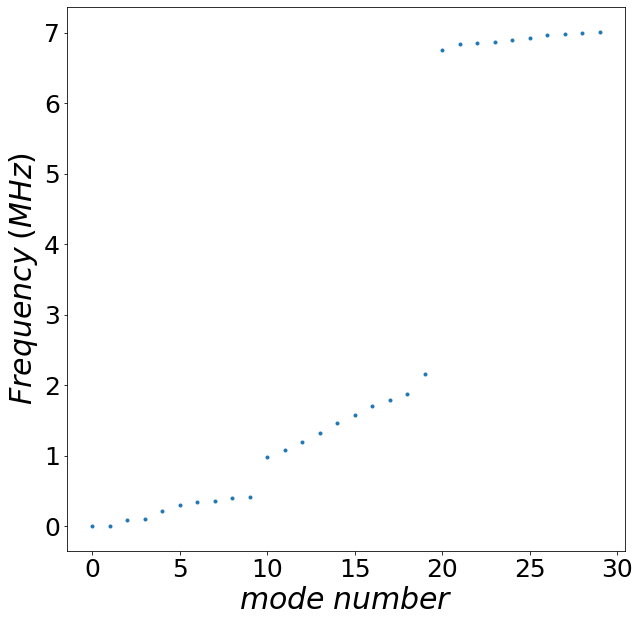

In [85]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.plot(np.arange(10*3), ma_instance_fmm.EvalsE3D/(2*np.pi*10**6), linestyle = " ", marker = ".")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$mode\;number$',fontsize = 30)
plt.ylabel(r'$Frequency\; (MHz)$',fontsize = 30)

[ 1.31252818e-07  2.24099495e-09  1.58615876e-09 -1.28056854e-09
 -1.17870513e-09  3.91446520e-09 -1.45519152e-10  7.45058060e-09
  9.31322575e-09  5.58793545e-09  0.00000000e+00  1.11758709e-08
 -1.11758709e-08  2.60770321e-08  9.68575478e-08 -4.47034836e-08
 -6.70552254e-08 -3.72529030e-08  3.72529030e-08  2.98023224e-08
  0.00000000e+00]


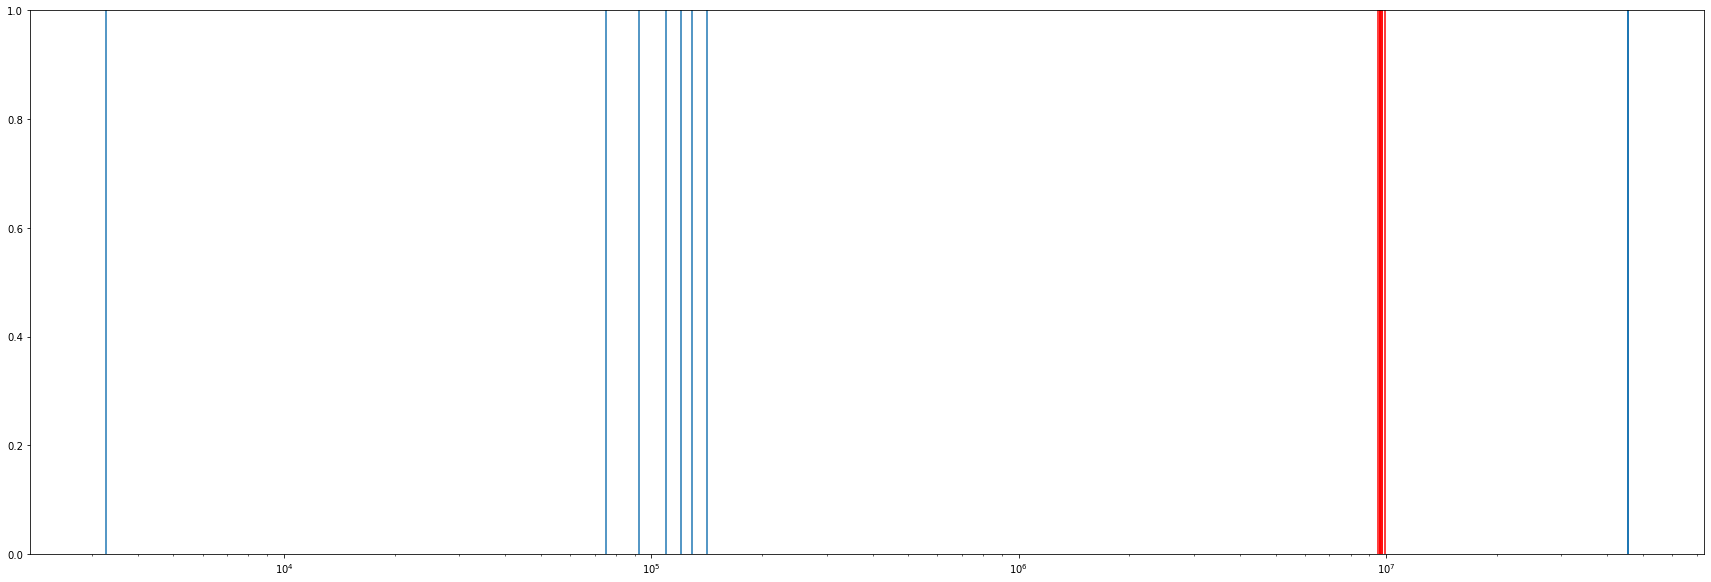

In [21]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot()
ax.set_xscale('log')
for ax_eig in ma_instance.axialEvalsE:
    ax.axvline(x = ax_eig, color = 'red')
for plan_eig in ma_instance.planarEvalsE:
    ax.axvline(x = plan_eig)
#for eig3D in ma_instance_fmm.EvalsE3D:
#    ax.axvline(x = eig3D)
eig2Dsort = np.sort(np.append(ma_instance.axialEvalsE,ma_instance.planarEvalsE))
eig3Dsort = np.sort(ma_instance_fmm.EvalsE3D)
print(eig2Dsort-eig3Dsort)

In [1]:
pos_fmm = ma_instance_fmm.uE
ax = plt.subplot()
ax.axis('equal')
ax.scatter(pos_fmm[0:ma_instance_fmm.Nion]*1e6,pos_fmm[ma_instance_fmm.Nion:]*1e6)
plt.show()
print(pos_fmm[:num_ions])
print(pos_fmm[num_ions:])

NameError: name 'ma_instance_fmm' is not defined

In [ ]:
ma_instance_fmm.show_axial_Evals()
print(ma_instance_fmm.axialEvals)
print(ma_instance_fmm.planarEvals)

In [ ]:
units  = 1e6
pos_nl = np.squeeze(results[0]['position']) 
pos_rot_nl= cry_mod.rotating_frame(pos_nl,omega=wrot,t_max=dt)[:,:,0]
pos_ax_nl = pos_nl[:,:,2]
ps_ax_nl,freq_norm_ax_nl = cry_mod.psd(pos_ax_nl,dt,units=units,log=True)
ps_nl,freq_norm_nl = cry_mod.psd(pos_rot_nl,dt,units=units,log=True)
all_normal_freqs = ma.planarEvalsE/units/2/np.pi
ax_normal_freqs = ma.axialEvalsE/units/2/np.pi



fig = plt.figure(figsize=(11,8.5),constrained_layout=False)
gs  = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[:, :])



ax_modes = np.arange(0,num_ions)
normal_freqs = ax_normal_freqs[ax_modes]
ax1.axvline(ma.wz/units/np.pi/2
            ,color='c'
            ,label=r'$f_z$'
            ,zorder=2)
cry_mod.plot_psd(freq_norm_ax_nl,ps_ax_nl,ax1,fig,
        label='Nonlinear Simulation',color='g'
        ,normal_freqs = normal_freqs)    
ax1.fill_between(freq_norm_ax_nl,ps_ax_nl,-30
        ,color='g'
        ,zorder=1
        )
secax_x = ax1.secondary_xaxis('top')
secax_x.set_xlabel('Mode #',fontsize=20)
labels  = np.array(list(map(str, (ax_modes+1))),dtype='<U5')
freqs,labels = cry_mod.get_mode_ticks(labels,normal_freqs)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
secax_x.set_xticks(freqs) 
secax_x.set_xticklabels(labels,fontsize=16)
ax1.legend(loc='lower left')
ax1.set_title('Axial Mode Spectrum',fontsize=30)



plt.show()




fig = plt.figure(figsize=(11,8.5),constrained_layout=False)
gs  = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])


mag_modes = np.arange(1,num_ions)
normal_freqs = all_normal_freqs[mag_modes]
ax1.axvline(omegaminus/units/np.pi/2
            ,color='c'
            ,label=r'$f_-$'
            ,zorder=2)
cry_mod.plot_psd(freq_norm,ps,ax1,fig,
        label='Linear Simulation   ',color='b')    
ax1.fill_between(freq_norm,ps,-30
        ,color='b'
        ,zorder=3
        )
cry_mod.plot_psd(freq_norm_nl,ps_nl,ax1,fig,
        label='Nonlinear Simulation',color='g'
        ,normal_freqs = normal_freqs)    
ax1.fill_between(freq_norm_nl,ps_nl,-30
        ,color='g'
        ,zorder=1
        )
secax_x = ax1.secondary_xaxis('top')
secax_x.set_xlabel('Mode #',fontsize=20)
labels  = np.array(list(map(str, (mag_modes+1))),dtype='<U5')
freqs,labels = cry_mod.get_mode_ticks(labels,normal_freqs)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
secax_x.set_xticks(freqs) 
secax_x.set_xticklabels(labels,fontsize=16)
ax1.legend(loc='lower left')
ax1.set_title('ExB Branch',fontsize=30)



cyc_modes = np.arange(num_ions,2*num_ions)
normal_freqs = all_normal_freqs[cyc_modes]
ax2.axvline(omegaplus/units/np.pi/2
            ,color='c'
            ,label=r'$f_+$'
            ,zorder=2)
cry_mod.plot_psd(freq_norm,ps,ax2,fig,
        label='Linear Simulation   '
        ,color='b'
        )
ax2.fill_between(freq_norm,ps,-30
        ,color='b'
        ,zorder=3
        )
cry_mod.plot_psd(freq_norm_nl,ps_nl,ax2,fig,
        label='Nonlinear Simulation'
        ,color='g'
        ,normal_freqs=normal_freqs)    
ax2.fill_between(freq_norm_nl,ps_nl,-30
        ,color='g'
        ,zorder=1
        )
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
secax_x = ax2.secondary_xaxis('top')
secax_x.set_xlabel('Mode #',fontsize=20)
labels  = np.array(list(map(str, (cyc_modes+1))),dtype='<U5')
freqs,labels = cry_mod.get_mode_ticks(labels,normal_freqs)
secax_x.set_xticks(freqs) 
secax_x.set_xticklabels(labels,fontsize=16)
ax2.legend(loc='lower left')
ax2.set_title('Cyclotron Branch',fontsize=30)
#ax2.set_xlim(0,omegaplus/units/np.pi/2)



plt.tight_layout()
#plt.savefig(pdir+'psd_comparison_nlVlin_'+lab_sim+'.png')
plt.show()






exit()


In [43]:
x = np.array([2,1,3])
y = np.array([5,4,6])
r = np.sqrt(x ** 2 + y ** 2)
print(x)
print(y)
print(r)
sort_ind = np.argsort(r)

r = r[sort_ind]
x = x[sort_ind]
y = y[sort_ind]
print(x)
print(y)
print(r)

dx = x.reshape((x.size, 1)) - x
print(dx)
dy = y.reshape((y.size, 1)) - y
print(dy)
rsep = np.sqrt(dx ** 2 + dy ** 2)
print(rsep)

with np.errstate(divide='ignore'):
    rsep3 = np.where(rsep != 0., rsep ** (-3), 0)
print(rsep3)

K = np.diag((-1 + 0.5 * np.sum(rsep3, axis=0)))
print(K)

K -= 0.5 * rsep3
print(K)

Zn = np.zeros((3, 3))
eyeN = np.identity(3)
print(Zn)
print(eyeN)
Mmat = np.diag(np.array([2,2,2]))
print(Mmat)
Minv = np.linalg.inv(Mmat)
firstOrder = np.bmat([[Zn, eyeN], [np.dot(Minv,K), Zn]])
print(firstOrder)

[2 1 3]
[5 4 6]
[5.38516481 4.12310563 6.70820393]
[1 2 3]
[4 5 6]
[4.12310563 5.38516481 6.70820393]
[[ 0 -1 -2]
 [ 1  0 -1]
 [ 2  1  0]]
[[ 0 -1 -2]
 [ 1  0 -1]
 [ 2  1  0]]
[[0.         1.41421356 2.82842712]
 [1.41421356 0.         1.41421356]
 [2.82842712 1.41421356 0.        ]]
[[0.         0.35355339 0.04419417]
 [0.35355339 0.         0.35355339]
 [0.04419417 0.35355339 0.        ]]
[[-0.80112622  0.          0.        ]
 [ 0.         -0.64644661  0.        ]
 [ 0.          0.         -0.80112622]]
[[-0.80112622 -0.1767767  -0.02209709]
 [-0.1767767  -0.64644661 -0.1767767 ]
 [-0.02209709 -0.1767767  -0.80112622]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[2 0 0]
 [0 2 0]
 [0 0 2]]
[[ 0.          0.          0.          1.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          1.        ]
 [-0.40056311 -0.08838835 -0.01104854  0.  

In [13]:
import numpy as np

x = np.array([0,1,5,3])
y = np.array([0,2,3,7])
dx = x.reshape((x.size, 1)) - x
dy = y.reshape((y.size, 1)) - y
rsep = np.sqrt(dx ** 2 + dy ** 2)

with np.errstate(divide='ignore'):
    rsep3 = np.where(rsep != 0., rsep ** (-3), 0)

Kp = np.diag((-1 + 0.5 * np.sum(rsep3, axis=0)))
K -= 0.5 * rsep3


print(dx)
print(dy)
print(rsep3)
print(Kp)
print(K)

[[ 0 -1 -5 -3]
 [ 1  0 -4 -2]
 [ 5  4  0  2]
 [ 3  2 -2  0]]
[[ 0 -2 -3 -7]
 [ 2  0 -1 -5]
 [ 3  1  0 -4]
 [ 7  5  4  0]]
[[0.         0.08944272 0.00504408 0.0022639 ]
 [0.08944272 0.         0.0142668  0.00640329]
 [0.00504408 0.0142668  0.         0.01118034]
 [0.0022639  0.00640329 0.01118034 0.        ]]
[[-0.95162465  0.          0.          0.        ]
 [ 0.         -0.9449436   0.          0.        ]
 [ 0.          0.         -0.98475439  0.        ]
 [ 0.          0.          0.         -0.99007623]]
[[-0.95162465 -0.13416408 -0.00756611 -0.00339586]
 [-0.13416408 -0.9449436  -0.0214002  -0.00960493]
 [-0.00756611 -0.0214002  -0.98475439 -0.01677051]
 [-0.00339586 -0.00960493 -0.01677051 -0.99007623]]


In [39]:
m = 9.012182*1.66057e-27
q = 1.602176597458587e-19
wz = 2*np.pi*1.58e6
wc = 4.4588*q/m
#wr = 180000*2*np.pi*20
wr = (wc-np.sqrt(wc**2-6*wz**2))/2
V0=(0.5 * m * wz**2) / q
Volt_w = 30
Volt_0 = V0 
delta = 1612.*Volt_w / Volt_0
Vw = 0.5*(m*wz**2/q)*delta
eps0 = 8.85418782*10**-12

def pot_eng_ax_pl_trap_3D(position):
    shape   = np.shape(position)
    dims,ions=shape
    x = position[0,:]
    y = position[1,:]
    z = position[2,:]
    pot_eng_ion = np.zeros((ions,2))
    #pot_eng_ion = np.zeros((ions,1))
    pot_eng_ion[:,0] = 0.5*m*wz**2*np.square(z)
    pot_eng_ion[:,1] += -0.5*m*(wr**2 - wr*wc + 0.5*wz**2) *(np.square(x)+np.square(y))
    pot_eng_ion[:,1] += q*Vw*(np.square(x)-np.square(y))
    return np.sum(pot_eng_ion)

def pot_eng_coul_3D(position):
    shape   = np.shape(position)
    dims,ions=shape
    x = position[0,:]
    y = position[1,:]
    z = position[2,:]
    pot_eng_ion = np.zeros(ions)
    for ion1 in range(ions):
        for ion2 in range(ions):
            if ion1!=ion2:
                dx = x[ion1] - x[ion2]
                dy = y[ion1] - y[ion2]
                dz = z[ion1] - z[ion2]
                r = np.sqrt(dx**2 + dy**2 + dz**2)
                #r = np.sqrt(dx**2 + dy**2)
                pot_eng_ion[ion1] += q**2/(4*np.pi*eps0*r)
    return np.sum(pot_eng_ion)/2

def pot_eng_coul_3D_fmm(position):
    shape   = np.shape(position)
    dims,ions=shape
    x = position[0,:]
    y = position[1,:]
    z = position[2,:]
    sources = np.array([x,y,z])
    charges = np.full(ions, 1.0)
    fmm_out = fmm.lfmm3d(eps=10**-5, sources=sources,charges=charges,dipvec=None,targets=None,pg=2,pgt=0,nd=1)
    #print(fmm_out.pot)
    Vc_tot = np.sum(fmm_out.pot) * q**2/(4*np.pi*eps0)
    return Vc_tot/2

    
def pot_en_3D(position):
    return pot_eng_ax_pl_trap_3D(position) + pot_eng_coul_3D(position)
#pot_en_3D(start_pos)
#print(pot_en_3D(start_pos))

def pot_en_3D_fmm(position):
    return pot_eng_ax_pl_trap_3D(position) + pot_eng_coul_3D_fmm(position)
#pot_en_3D_fmm(start_pos)

In [40]:
def force_penning3D(pos_array, Nion):
        """
        Computes the net forces acting on each ion in the crystal;
        used as the jacobian by find_eq_pos to minimize the potential energy
        of a crystal configuration.

        :param pos_array: crystal to find forces of.
        :return: a vector of size 2N describing the x forces and y forces.
        """

        x = pos_array[0:Nion]
        y = pos_array[Nion:2*Nion]
        z = pos_array[2*Nion:3*Nion]
        
        sources = np.array([x,y,z])
        q= 1.60217663 * 10**-19
        charges = np.full(Nion, q)
        fmm_out = fmm.lfmm3d(eps=10**-9, sources=sources,charges=charges,dipvec=None,targets=None,pg=2,pgt=0,nd=1)
        #print(fmm_out.pot)
        #print("start")
        #print(fmm_out.grad)
        #print("end")
        fx = fmm_out.grad[0]*q/(4*np.pi*eps0)
        fy = fmm_out.grad[1]*q/(4*np.pi*eps0)
        fz = fmm_out.grad[2]*q/(4*np.pi*eps0)
        #print(fx)

        '''
        dx = x.reshape((x.size, 1)) - x
        dy = y.reshape((y.size, 1)) - y
        dz = z.reshape((z.size, 1)) - z
        rsep = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

        # Calculate coulomb force on each ion
        with np.errstate(divide='ignore'):
            Fc = np.where(rsep != 0., rsep ** (-2), 0)

        with np.errstate(divide='ignore', invalid='ignore'):
            fx = np.where(rsep != 0., np.float64((dx / rsep) * Fc), 0)
            fy = np.where(rsep != 0., np.float64((dy / rsep) * Fc), 0)
            fz = np.where(rsep != 0., np.float64((dz / rsep) * Fc), 0)
        '''

        # total force on each ion

        """ Deprecated version below which uses anharmonic trap potentials
        Ftrapx = (-m * wr ** 2 - q * self.Coeff[2] + q * B * wr + 2 * self.Cw2) * x \
            - 4 * q * self.Coeff[3] * (x ** 3 + x * y ** 2) + 3 * self.Cw3 * (x ** 2 - y ** 2)
        Ftrapy = (-m * wr ** 2 - q * self.Coeff[2] + q * B * wr - 2 * self.Cw2) * y \
            - 4 * q * self.Coeff[3] * (y ** 3 + y * x ** 2) - 6 * self.Cw3 * x * y

        # Ftrap =  (m*w**2 + q*self.V0 - 2*q*self.Vw - q*self.B* w) * pos_array
        """
        m = 9.012182*1.66057*10**-27
        Ftrapx = -m * (wr ** 2 - wr * wc + 0.5*wz**2 -
                                 q*Vw) * x
        Ftrapy = -m * (wr ** 2 - wr * wc + 0.5*wz**2 +
                                 q*Vw) * y
        Ftrapz =  m * wz**2*z
        Fx = +fx + Ftrapx
        Fy = +fy + Ftrapy
        Fz = +fz + Ftrapz

        return np.array([Fx, Fy, Fz]).flatten()

In [41]:
pos_load = np.concatenate((load_xrot,load_yrot,load_zrot), axis= None)
forces = force_penning3D(pos_load, 236)
forces3D = np.zeros(236)
for i in range(236):
    forces3D = (forces[i]**2 + forces[i+236]**2 + forces[i+2*236]**2)**0.5
print(np.mean(forces3D))

3.206961630717153e-19


In [8]:
initial = np.array([load_xrot, load_yrot, load_zrot])
final = np.array([ma_instance_fmm.uE[0:236], ma_instance_fmm.uE[236:2*236], ma_instance_fmm.uE[2*236:3*236]])
print(pot_en_3D_fmm(initial))
print(pot_en_3D_fmm(final))

3.383253747125708e-19
3.383251615568359e-19


In [7]:
nion=5000
np.savetxt("5000i_ma_min_x_051823.csv", ma_instance_fmm.uE[0:nion], delimiter=",")
np.savetxt("5000i_ma_min_y_051823.csv", ma_instance_fmm.uE[nion:2*nion], delimiter=",")
np.savetxt("5000i_ma_min_z_051823.csv", ma_instance_fmm.uE[2*nion:3*nion], delimiter=",")

In [3]:
m = 9.012182*1.66057e-27
q = 1.602176597458587e-19
wz = 2*np.pi*1.58e6
wc = 4.4588*q/m
#wr = 180000*2*np.pi*20
wr = (wc-np.sqrt(wc**2-6*wz**2))/2
V0=(0.5 * m * wz**2) / q
Volt_w = 30
Volt_0 = V0 
delta = 1612.*Volt_w / Volt_0
Vw = 0.5*(m*wz**2/q)*delta
eps0 = 8.85418782*10**-12
nion=236

def pot_eng_ax_pl_trap_3D(position):
    #shape   = np.shape(position)
    #dims,ions=shape
    x = position[0:nion]
    y = position[nion:2*nion]
    z = position[2*nion:3*nion]
    pot_eng_ion = np.zeros((nion,2))
    #pot_eng_ion = np.zeros((ions,1))
    pot_eng_ion[:,0] = 0.5*m*wz**2*np.square(z)
    pot_eng_ion[:,1] += -0.5*m*(wr**2 - wr*wc + 0.5*wz**2) *(np.square(x)+np.square(y))
    pot_eng_ion[:,1] += q*Vw*(np.square(x)-np.square(y))
    return np.sum(pot_eng_ion)
'''
def pot_eng_coul_3D(position):
    #shape   = np.shape(position)
    #dims,ions=shape
    x = position[0:100]
    y = position[101:200]
    z = position[201:300]
    pot_eng_ion = np.zeros(ions)
    for ion1 in range(ions):
        for ion2 in range(ions):
            if ion1!=ion2:
                dx = x[ion1] - x[ion2]
                dy = y[ion1] - y[ion2]
                dz = z[ion1] - z[ion2]
                r = np.sqrt(dx**2 + dy**2 + dz**2)
                #r = np.sqrt(dx**2 + dy**2)
                pot_eng_ion[ion1] += q**2/(4*np.pi*eps0*r)
    return np.sum(pot_eng_ion)/2
'''
def pot_eng_coul_3D_fmm(position):
    #shape   = np.shape(position)
    #dims,ions=shape
    x = position[0:nion]
    y = position[nion:2*nion]
    z = position[2*nion:3*nion]
    sources = np.array([x,y,z])
    charges = np.full(nion, 1.0)
    fmm_out = fmm.lfmm3d(eps=10**-5, sources=sources,charges=charges,dipvec=None,targets=None,pg=2,pgt=0,nd=1)
    #print(fmm_out.pot)
    Vc_tot = np.sum(fmm_out.pot) * q**2/(4*np.pi*eps0)
    return Vc_tot/2

'''    
def pot_en_3D(position):
    return pot_eng_ax_pl_trap_3D(position) + pot_eng_coul_3D(position)
pot_en_3D(start_pos)
'''
def pot_en_3D_fmm(position):
    return 10**20*(pot_eng_ax_pl_trap_3D(position) + pot_eng_coul_3D_fmm(position))

In [47]:
lw = [-40* 10**-6] * 236*3
up = [40* 10**-6] * 236*3
ret = optimize.dual_annealing(pot_en_3D_fmm, bounds=list(zip(lw, up)), restart_temp_ratio=0.5, maxiter=20)

In [38]:
ret2 = optimize.dual_annealing(pot_en_3D_fmm, bounds=list(zip(ret.x-0.1*np.absolute(ret.x), ret.x+0.1*np.absolute(ret.x))), initial_temp=10**-8, restart_temp_ratio=0.5, maxiter=5)

In [66]:
initial = np.array([load_xrot, load_yrot, load_zrot])
#final = np.array([ma_instance_fmm.uE[0:236], ma_instance_fmm.uE[236:2*236], ma_instance_fmm.uE[2*236:3*236]])
print(pot_en_3D_fmm(initial))
#print(pot_en_3D_fmm(final))

3.383289229768676e-19


In [46]:
print(ret)

     fun: 33.83449736403265
 message: ['Maximum number of iteration reached']
    nfev: 51045
    nhev: 0
     nit: 3
    njev: 66
  status: 0
 success: True
       x: array([ 1.28944189e-05, -1.76729598e-05, -1.35128025e-05,  1.36551553e-05,
        7.27010219e-07,  2.89247303e-06, -2.82436315e-05, -1.40525074e-05,
        2.08778346e-06, -1.60539319e-05, -9.38494909e-06, -1.30921387e-05,
       -4.26181580e-06, -3.12645661e-06, -2.48065307e-05, -8.67903258e-06,
        1.04371817e-05,  1.85104750e-05, -1.70583494e-05, -2.91416717e-05,
       -2.17057496e-05,  6.55383417e-06, -5.64729777e-07,  9.64892810e-07,
       -2.02781259e-05,  1.57692968e-05,  1.44874822e-05, -6.37419742e-06,
       -5.59647699e-07, -5.22880973e-06,  1.29742862e-05,  9.12288452e-06,
        4.18362446e-06,  6.22098426e-06,  3.37225995e-06, -4.51159909e-06,
       -1.04469918e-05, -2.05856993e-05,  1.35171213e-05, -1.72213001e-05,
        1.19565761e-05,  2.88763879e-06, -4.63174657e-06,  1.38378849e-05,
       

In [20]:
print(pot_en_3D_fmm(ret.x)/(10**20))

3.3833270186486997e-19


In [ ]:
import random
ret_bh = optimize.basinhopping(pot_en_3D_fmm, (np.random.rand(236*3)-0.5)*10**5, niter=100, T = 10**-2, bounds=list(zip(lw, up)), restart_temp_ratio=0.5, maxiter=3)

(array([-100.,  -75.,  -50.,  -25.,    0.,   25.,   50.,   75.,  100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

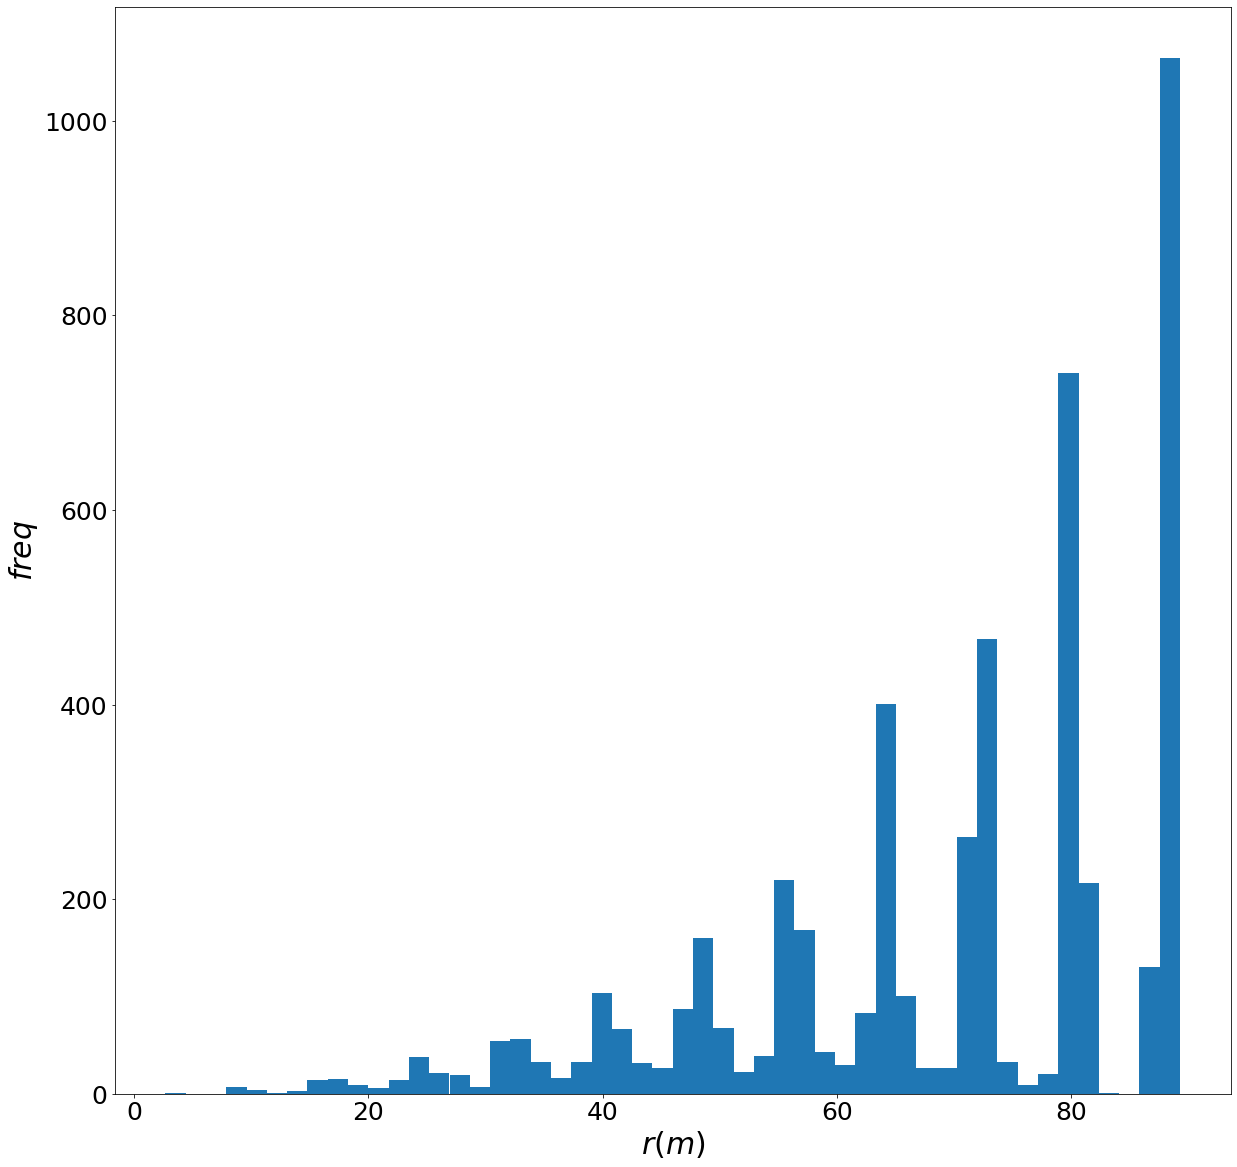

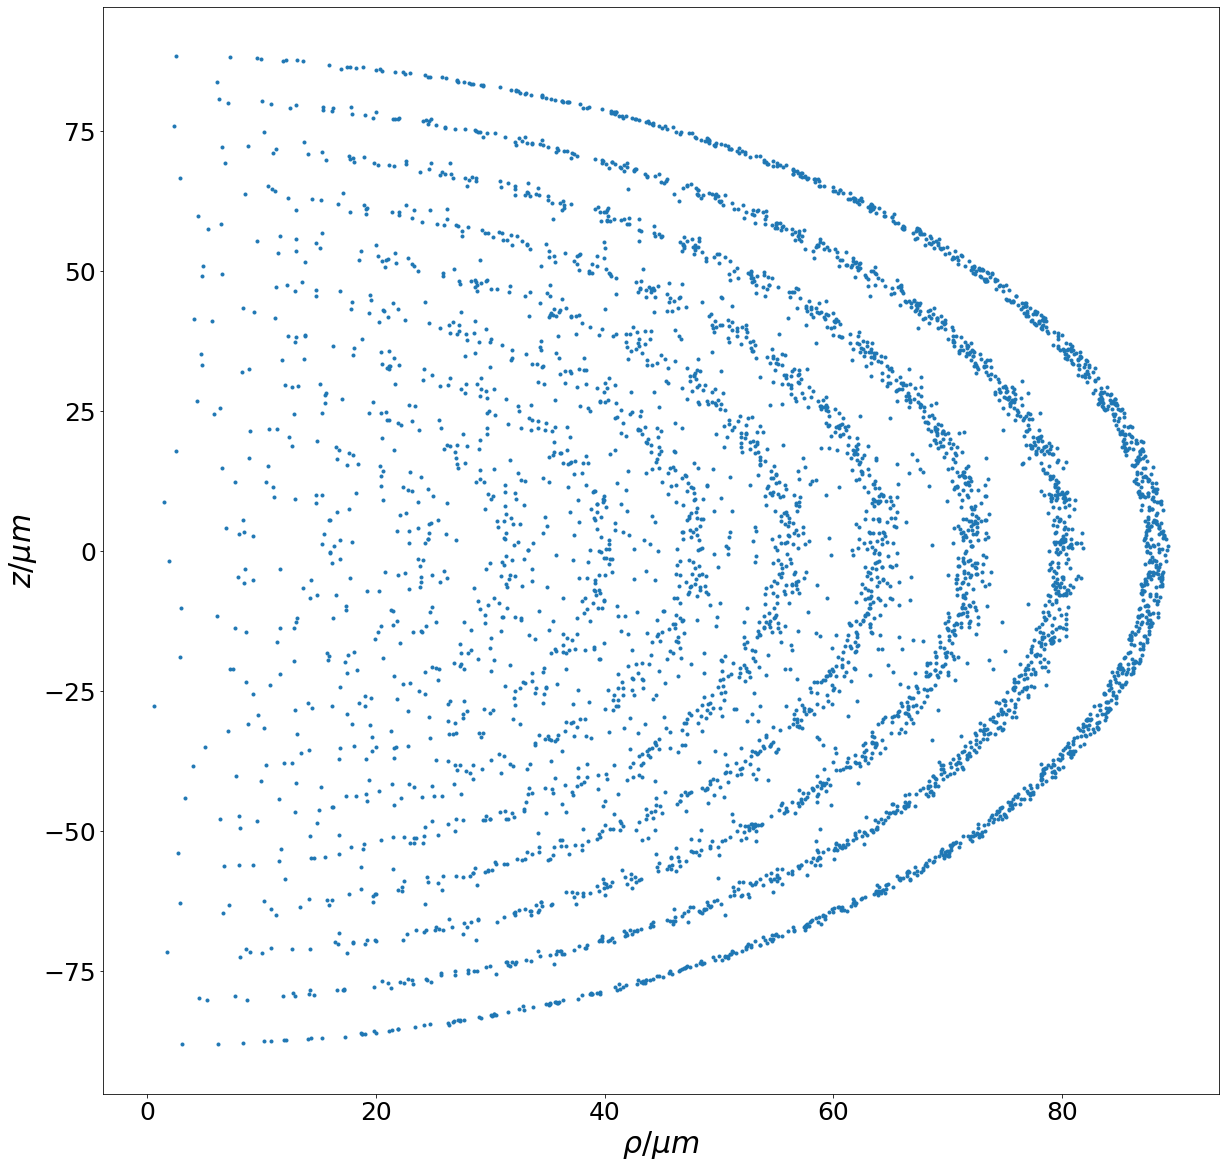

In [6]:
%matplotlib inline
nion = 5000
plt.figure(figsize=(20, 20))
rad_list = np.sqrt(ma_instance_fmm.uE[0:nion]**2+ma_instance_fmm.uE[nion:2*nion]**2+ma_instance_fmm.uE[2*nion:3*nion]**2)
plt.hist(10**6*rad_list,50)
plt.xlabel(r'$r(m)$', fontsize = 30)
plt.ylabel(r'$freq$', fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

rho_list = np.sqrt(ma_instance_fmm.uE[0:nion]**2+ma_instance_fmm.uE[nion:2*nion]**2)
plt.figure(figsize=(20, 20))
#plt.figure()
plt.plot(10**6*rho_list, 10**6*ma_instance_fmm.uE[2*nion:3*nion], linestyle = " ", marker = ".")
plt.xlabel(r'$\rho/\mu m$', fontsize = 30)
plt.ylabel(r'$z/\mu m$', fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

In [7]:
m = 9.012182*1.66057e-27
q = 1.602176597458587e-19
wz = 2*np.pi*1.58e6
k_e = 8.9875517873681764*10**9
l0 = ((k_e * q ** 2) / (.5 * m * wz ** 2)) ** (1 / 3)
E0 = 0.5*m*(wz**2)*l0**2 # characteristic energy
en = np.array([9955.249787206358,9955.256676682626,9955.314449610734,9955.245592148205,9955.247631704518,9955.256785585769,
      9955.207965830465,9955.281503590406,9955.233654312811,9955.233444734256,9955.35352275899,9955.302121828594,
      9955.23890414068,9955.251865083954,9955.219981075956,9955.227888645102,9955.29628751889,9955.246809148513,
      9955.21952500649,9955.25237426686,9955.280703302396])*E0
print(en)

[3.38327497e-19 3.38327731e-19 3.38329695e-19 3.38327354e-19
 3.38327424e-19 3.38327735e-19 3.38326076e-19 3.38328575e-19
 3.38326949e-19 3.38326942e-19 3.38331022e-19 3.38329276e-19
 3.38327127e-19 3.38327568e-19 3.38326484e-19 3.38326753e-19
 3.38329077e-19 3.38327396e-19 3.38326469e-19 3.38327585e-19
 3.38328548e-19]


(array([3., 3., 5., 4., 1., 1., 2., 1., 0., 1.]),
 array([3.38326076e-19, 3.38326570e-19, 3.38327065e-19, 3.38327560e-19,
        3.38328054e-19, 3.38328549e-19, 3.38329044e-19, 3.38329538e-19,
        3.38330033e-19, 3.38330528e-19, 3.38331022e-19]),
 <BarContainer object of 10 artists>)

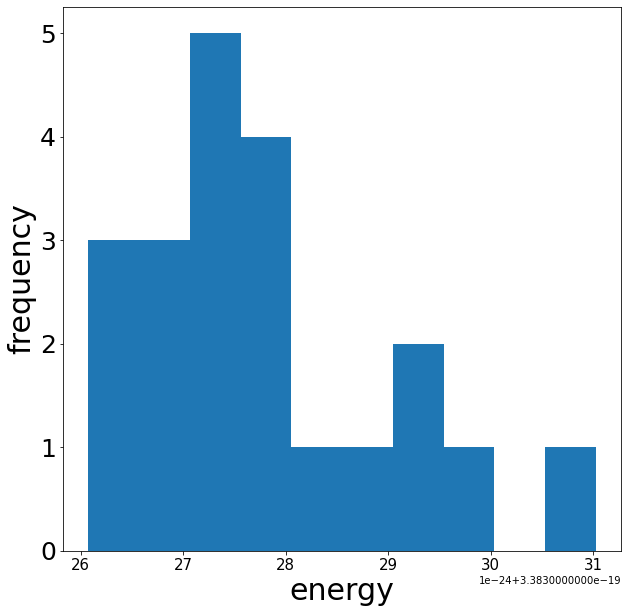

In [10]:
plt.figure(figsize=(10, 10))
plt.xlabel(r'energy',fontsize = 30)
plt.ylabel(r'frequency',fontsize = 30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)
plt.hist(en)